# 🐦 Мониторинг птиц по аудиозаписям с помощью BirdNET

**Университетский практикум по машинному обучению**

---

## Описание проекта

В этом ноутбуке мы используем предобученную модель **BirdNET** для идентификации видов птиц по аудиозаписям. BirdNET — это нейронная сеть, разработанная Cornell Lab of Ornithology и Chemnitz University of Technology, способная распознавать более 6000 видов птиц.

### Структура ноутбука:
1. Установка зависимостей
2. Импорт библиотек
3. Загрузка тестовых данных с Xeno-Canto
4. Анализ одного аудиофайла
5. Визуализация спектрограммы
6. Пакетная обработка нескольких файлов
7. Сводная таблица результатов
8. Выводы и применения


---
## 1. Установка зависимостей

Выполните эту ячейку для установки всех необходимых библиотек.

> **Примечание**: При запуске в Google Colab ячейка автоматически определит окружение и установит нужные пакеты.


In [1]:
# Проверяем, запущены ли мы в Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Обнаружен Google Colab. Устанавливаем зависимости...")
    %pip install -q birdnetlib librosa matplotlib seaborn pandas tqdm
    
    # Клонируем репозиторий если нужен доступ к модулям src
    # !git clone https://github.com/your-username/bird-sound-monitoring.git
    # %cd bird-sound-monitoring
else:
    print("✅ Локальное окружение. Убедитесь, что зависимости установлены:")
    print("   pip install -r requirements.txt")

print("\n📦 Проверка установленных пакетов:")
%pip show birdnetlib | grep -E "Name|Version"


✅ Локальное окружение. Убедитесь, что зависимости установлены:
   pip install -r requirements.txt

📦 Проверка установленных пакетов:
Name: birdnetlib
Version: 0.18.0
Location: /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages
Note: you may need to restart the kernel to use updated packages.


---
## 2. Импорт библиотек

Импортируем все необходимые модули для работы.


In [2]:
# Стандартные библиотеки
import os
import sys
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')  # Скрываем предупреждения для чистого вывода

# Научные библиотеки
import numpy as np
import pandas as pd

# Обработка аудио
import librosa
import librosa.display

# Визуализация
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# BirdNET
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer

# Утилиты
from tqdm.notebook import tqdm
import requests

# Настройка отображения
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Добавляем путь к нашим модулям (для локального запуска)
if not IN_COLAB:
    sys.path.insert(0, str(Path.cwd().parent))
    try:
        from src import BirdClassifier, load_audio, plot_spectrogram
        print("✅ Модули src успешно импортированы")
    except ImportError:
        print("⚠️ Модули src не найдены, используем встроенные функции")

print("\n✅ Все библиотеки успешно импортированы!")
print(f"📅 Дата запуска: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


✅ Модули src успешно импортированы

✅ Все библиотеки успешно импортированы!
📅 Дата запуска: 2025-12-11 14:15


---
## 3. Загрузка тестовых данных

Скачиваем примеры аудиозаписей птиц из открытых источников (Wikimedia Commons).

### Выбранные записи:
- Большая синица (Parus major)
- Соловей (Luscinia megarhynchos)
- Зяблик (Fringilla coelebs)
- Чёрный дрозд (Turdus merula)
- Кукушка (Cuculus canorus)


In [3]:
# Создаём папку для данных
DATA_DIR = Path("../data/samples") if not IN_COLAB else Path("./samples")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Список записей для скачивания
# Используем прямые ссылки на аудиофайлы из Wikimedia Commons
# Формат: (URL, название файла, русское название)
SAMPLE_RECORDINGS = [
    ("https://upload.wikimedia.org/wikipedia/commons/e/eb/Parus_major_song.ogg", 
     "great_tit.ogg", "Большая синица"),
    ("https://upload.wikimedia.org/wikipedia/commons/c/c1/Nightingale_%28Luscinia_megarhynchos%29.ogg", 
     "nightingale.ogg", "Соловей"),
    ("https://upload.wikimedia.org/wikipedia/commons/b/bb/Fringilla_coelebs_song.ogg", 
     "chaffinch.ogg", "Зяблик"),
    ("https://upload.wikimedia.org/wikipedia/commons/3/3f/Cuculus_canorus_song.ogg", 
     "cuckoo.ogg", "Кукушка"),
    ("https://upload.wikimedia.org/wikipedia/commons/3/30/Common_Blackbird_song_%28Turdus_merula%29.ogg", 
     "blackbird.ogg", "Чёрный дрозд"),
]

def download_audio(url: str, output_path: Path) -> bool:
    """
    Скачивает аудиофайл по прямой ссылке.
    
    Args:
        url: URL аудиофайла
        output_path: Путь для сохранения файла
    
    Returns:
        True если успешно, False при ошибке
    """
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        response = requests.get(url, timeout=60, headers=headers)
        response.raise_for_status()
        
        with open(output_path, 'wb') as f:
            f.write(response.content)
        
        return True
        
    except Exception as e:
        print(f"  ❌ Ошибка: {e}")
        return False

# Скачиваем записи
print("📥 Загрузка примеров аудиозаписей птиц...\n")
downloaded_files = []

for url, filename, bird_name in SAMPLE_RECORDINGS:
    filepath = DATA_DIR / filename
    
    if filepath.exists():
        print(f"  ✓ {bird_name} ({filename}) — уже скачан")
        downloaded_files.append(str(filepath))
    else:
        print(f"  ↓ Скачиваем {bird_name}...", end=" ")
        if download_audio(url, filepath):
            print("✓")
            downloaded_files.append(str(filepath))
        else:
            print("✗")

print(f"\n📁 Скачано файлов: {len(downloaded_files)} из {len(SAMPLE_RECORDINGS)}")
print(f"📂 Папка с данными: {DATA_DIR.absolute()}")


📥 Загрузка примеров аудиозаписей птиц...

  ✓ Большая синица (great_tit.ogg) — уже скачан
  ✓ Соловей (nightingale.ogg) — уже скачан
  ✓ Зяблик (chaffinch.ogg) — уже скачан
  ✓ Кукушка (cuckoo.ogg) — уже скачан
  ✓ Чёрный дрозд (blackbird.ogg) — уже скачан

📁 Скачано файлов: 5 из 5
📂 Папка с данными: /Users/owenrouze/Desktop/Projects/praktika/bird-sound-monitoring/notebooks/../data/samples


In [4]:
# Инициализируем анализатор BirdNET
# При первом запуске модель будет загружена автоматически (может занять время)
print("🔄 Загрузка модели BirdNET...")
analyzer = Analyzer()
print("✅ Модель успешно загружена!\n")


🔄 Загрузка модели BirdNET...
Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
✅ Модель успешно загружена!



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
# Выбираем первый файл для демонстрации
if downloaded_files:
    demo_file = downloaded_files[0]
else:
    # Если файлы не скачались, используем заглушку
    demo_file = str(DATA_DIR / "great_tit.mp3")

print(f"📂 Анализируем файл: {os.path.basename(demo_file)}\n")

# Параметры анализа
# BirdNET использует координаты и дату для фильтрации видов по региону
LATITUDE = 55.75   # Широта (Москва для примера)
LONGITUDE = 37.62  # Долгота
DATE = datetime(2025, 5, 15)  # Дата записи (весна - время пения)
MIN_CONFIDENCE = 0.25  # Минимальный порог уверенности (25%)

# Создаём объект Recording для анализа
recording = Recording(
    analyzer,
    demo_file,
    lat=LATITUDE,
    lon=LONGITUDE,
    date=DATE,
    min_conf=MIN_CONFIDENCE
)

# Выполняем анализ
print("🔍 Анализ аудиозаписи...")
recording.analyze()

# Выводим результаты
print(f"\n✅ Анализ завершён!")
print(f"⏱️  Длительность записи: {recording.duration:.1f} секунд")
print(f"🐦 Обнаружено птиц: {len(recording.detections)}\n")

# Показываем детальные результаты
if recording.detections:
    print("=" * 70)
    print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ")
    print("=" * 70)
    
    for i, detection in enumerate(recording.detections, 1):
        print(f"\n{i}. {detection['common_name']}")
        print(f"   Научное название: {detection['scientific_name']}")
        print(f"   Уверенность: {detection['confidence']:.1%}")
        print(f"   Время: {detection['start_time']:.1f} - {detection['end_time']:.1f} сек")
else:
    print("❌ Птицы не обнаружены. Попробуйте понизить порог уверенности.")


📂 Анализируем файл: great_tit.ogg

🔍 Анализ аудиозаписи...
read_audio_data
read_audio_data: complete, read  6 chunks.
analyze_recording great_tit.ogg
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
18
366 species loaded.

✅ Анализ завершён!
⏱️  Длительность записи: 18.9 секунд
🐦 Обнаружено птиц: 6

РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ

1. Great Tit
   Научное название: Parus major
   Уверенность: 100.0%
   Время: 0.0 - 3.0 сек

2. Great Tit
   Научное название: Parus major
   Уверенность: 99.9%
   Время: 3.0 - 6.0 сек

3. Great Tit
   Научное название: Parus major
   Уверенность: 99.8%
   Время: 6.0 - 9.0 сек

4. Great Tit
   Научное название: Parus major
   Уверенность: 99.2%
   Время: 9.0 - 12.0 сек

5. Great Tit
   Научное название: Parus major
   Уверенность: 94.2%
   Время: 12.0 - 15.0 сек

6. Great Tit
   Научное название: Parus major
   Уверенность: 99.4%
   Время: 15.0 - 18.0 сек


---
## 5. Визуализация спектрограммы

Спектрограмма показывает частотный состав звука во времени. Это основной инструмент анализа в биоакустике.


In [6]:
# Загружаем аудио для визуализации
print(f"📊 Загружаем аудио для визуализации: {os.path.basename(demo_file)}")

# librosa загружает аудио и конвертирует в нужный формат
audio, sr = librosa.load(demo_file, sr=48000)  # 48kHz - стандарт для BirdNET

print(f"   Частота дискретизации: {sr} Hz")
print(f"   Длительность: {len(audio)/sr:.2f} секунд")
print(f"   Количество сэмплов: {len(audio):,}")


📊 Загружаем аудио для визуализации: great_tit.ogg
   Частота дискретизации: 48000 Hz
   Длительность: 18.92 секунд
   Количество сэмплов: 908,114


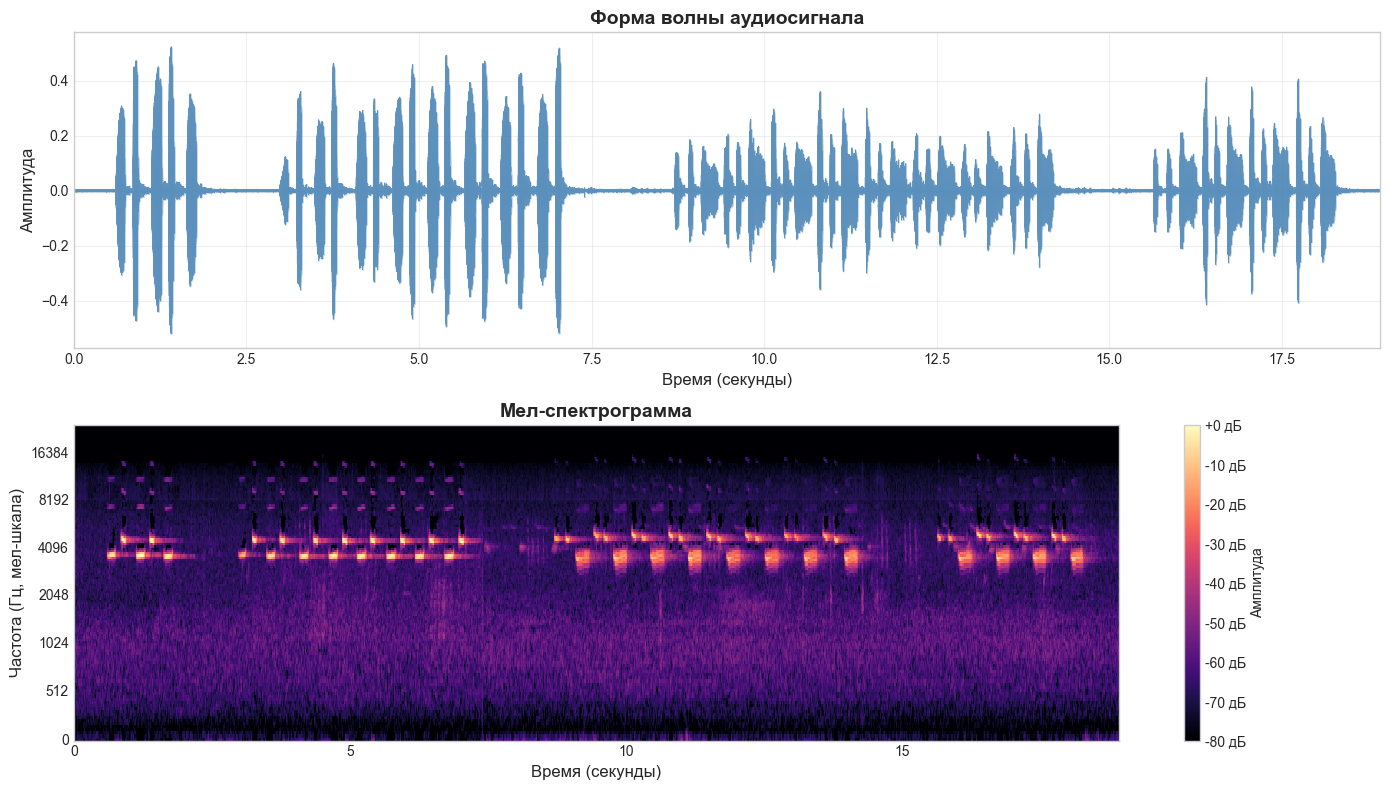


💡 На спектрограмме видны характерные паттерны пения птиц — горизонтальные и наклонные линии.


In [7]:
# Создаём спектрограмму
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 1. Форма волны (waveform)
ax1 = axes[0]
times = np.linspace(0, len(audio) / sr, num=len(audio))
ax1.plot(times, audio, color='steelblue', linewidth=0.5, alpha=0.8)
ax1.fill_between(times, audio, alpha=0.3, color='steelblue')
ax1.set_xlabel('Время (секунды)', fontsize=12)
ax1.set_ylabel('Амплитуда', fontsize=12)
ax1.set_title('Форма волны аудиосигнала', fontsize=14, fontweight='bold')
ax1.set_xlim(0, times[-1])
ax1.grid(alpha=0.3)

# 2. Мел-спектрограмма
ax2 = axes[1]
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax2, cmap='magma')
ax2.set_xlabel('Время (секунды)', fontsize=12)
ax2.set_ylabel('Частота (Гц, мел-шкала)', fontsize=12)
ax2.set_title('Мел-спектрограмма', fontsize=14, fontweight='bold')
fig.colorbar(img, ax=ax2, format='%+2.0f дБ', label='Амплитуда')

plt.tight_layout()
plt.show()

print("\n💡 На спектрограмме видны характерные паттерны пения птиц — горизонтальные и наклонные линии.")


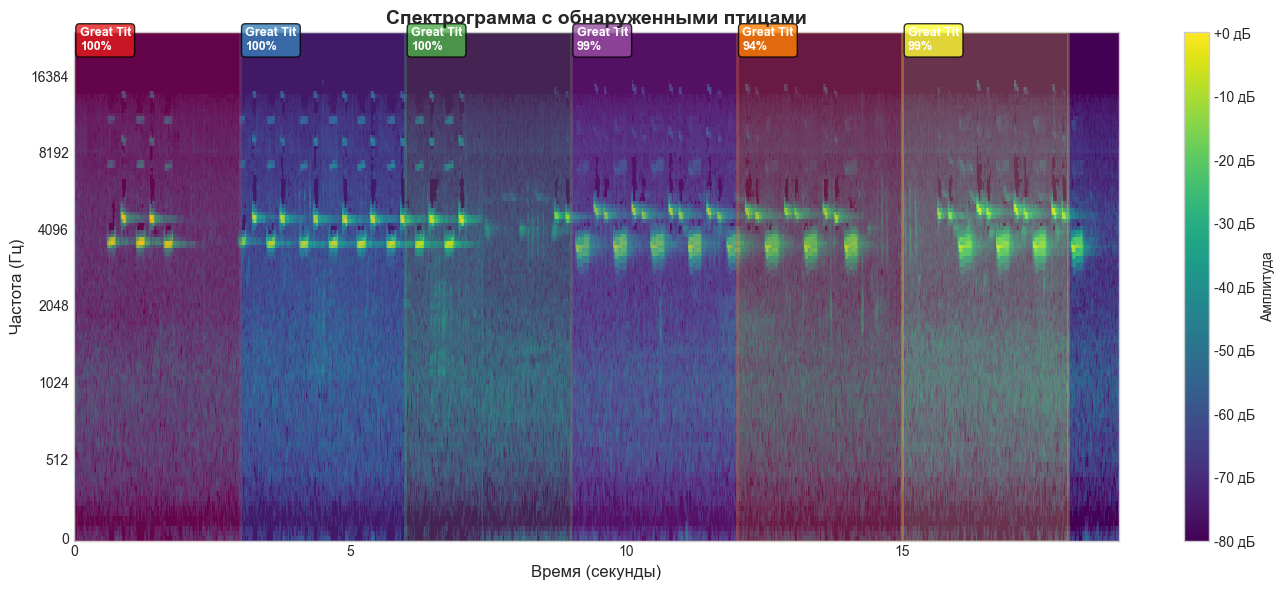

In [8]:
# Спектрограмма с отмеченными обнаружениями
fig, ax = plt.subplots(figsize=(14, 6))

# Отображаем спектрограмму
img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')

# Получаем границы для прямоугольников
y_min, y_max = ax.get_ylim()

# Цвета для разных видов
colors = plt.cm.Set1.colors

# Рисуем прямоугольники для обнаружений
if recording.detections:
    for i, det in enumerate(recording.detections):
        color = colors[i % len(colors)]
        
        # Прямоугольник
        rect = patches.Rectangle(
            (det['start_time'], y_min),
            det['end_time'] - det['start_time'],
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor=color,
            alpha=0.2
        )
        ax.add_patch(rect)
        
        # Подпись
        label = f"{det['common_name']}\n{det['confidence']:.0%}"
        ax.annotate(
            label,
            xy=(det['start_time'] + 0.1, y_max * 0.85),
            fontsize=9,
            color='white',
            fontweight='bold',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8)
        )

ax.set_title('Спектрограмма с обнаруженными птицами', fontsize=14, fontweight='bold')
ax.set_xlabel('Время (секунды)', fontsize=12)
ax.set_ylabel('Частота (Гц)', fontsize=12)
fig.colorbar(img, ax=ax, format='%+2.0f дБ', label='Амплитуда')

plt.tight_layout()
plt.show()


---
## 6. Пакетная обработка (Batch Processing)

Анализируем все скачанные файлы одновременно.


In [9]:
# Функция для пакетного анализа
def analyze_batch(filepaths, analyzer, lat=55.75, lon=37.62, date=None, min_conf=0.25):
    """
    Анализирует список аудиофайлов.
    
    Args:
        filepaths: Список путей к файлам
        analyzer: Инициализированный Analyzer
        lat, lon: Координаты
        date: Дата записи
        min_conf: Минимальная уверенность
    
    Returns:
        Список результатов анализа
    """
    if date is None:
        date = datetime.now()
    
    results = []
    
    for filepath in tqdm(filepaths, desc="Анализ файлов"):
        try:
            rec = Recording(
                analyzer,
                filepath,
                lat=lat,
                lon=lon,
                date=date,
                min_conf=min_conf
            )
            rec.analyze()
            
            results.append({
                'filepath': filepath,
                'filename': os.path.basename(filepath),
                'duration': rec.duration,
                'num_detections': len(rec.detections),
                'detections': rec.detections
            })
        except Exception as e:
            print(f"\n❌ Ошибка при анализе {filepath}: {e}")
            results.append({
                'filepath': filepath,
                'filename': os.path.basename(filepath),
                'duration': 0,
                'num_detections': 0,
                'detections': [],
                'error': str(e)
            })
    
    return results

# Анализируем все файлы
print(f"🔄 Запуск пакетного анализа {len(downloaded_files)} файлов...\n")

batch_results = analyze_batch(
    downloaded_files,
    analyzer,
    lat=LATITUDE,
    lon=LONGITUDE,
    date=DATE,
    min_conf=MIN_CONFIDENCE
)

print(f"\n✅ Анализ завершён!")


🔄 Запуск пакетного анализа 5 файлов...



Анализ файлов:   0%|          | 0/5 [00:00<?, ?it/s]

read_audio_data
read_audio_data: complete, read  6 chunks.
analyze_recording great_tit.ogg
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  26 chunks.
analyze_recording nightingale.ogg
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  43 chunks.
analyze_recording chaffinch.ogg
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  13 chunks.
analyze_recording cuckoo.ogg
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  23 chunks.
analyze_recording blackbird.ogg
recording has lon/lat
set_predicted_species_list_from_position

✅ Анализ завершён!


In [10]:
# Выводим сводку по каждому файлу
print("\n" + "=" * 80)
print("СВОДКА ПО ФАЙЛАМ")
print("=" * 80)

for result in batch_results:
    print(f"\n📁 {result['filename']}")
    print(f"   Длительность: {result['duration']:.1f} сек")
    print(f"   Обнаружений: {result['num_detections']}")
    
    if result['detections']:
        # Топ обнаружение
        top = max(result['detections'], key=lambda x: x['confidence'])
        print(f"   🏆 Топ: {top['common_name']} ({top['confidence']:.0%})")



СВОДКА ПО ФАЙЛАМ

📁 great_tit.ogg
   Длительность: 18.9 сек
   Обнаружений: 6
   🏆 Топ: Great Tit (100%)

📁 nightingale.ogg
   Длительность: 77.8 сек
   Обнаружений: 18
   🏆 Топ: Common Nightingale (100%)

📁 chaffinch.ogg
   Длительность: 128.0 сек
   Обнаружений: 15
   🏆 Топ: Common Chaffinch (92%)

📁 cuckoo.ogg
   Длительность: 39.1 сек
   Обнаружений: 10
   🏆 Топ: Common Cuckoo (60%)

📁 blackbird.ogg
   Длительность: 70.0 сек
   Обнаружений: 16
   🏆 Топ: Mistle Thrush (97%)


---
## 7. Сводная таблица результатов

Создаём структурированную таблицу со всеми обнаружениями.


In [11]:
# Собираем все обнаружения в DataFrame
all_detections = []

for result in batch_results:
    for det in result['detections']:
        all_detections.append({
            'Файл': result['filename'],
            'Вид (англ.)': det['common_name'],
            'Научное название': det['scientific_name'],
            'Уверенность': det['confidence'],
            'Начало (сек)': det['start_time'],
            'Конец (сек)': det['end_time']
        })

# Создаём DataFrame
df_detections = pd.DataFrame(all_detections)

if not df_detections.empty:
    # Сортируем по уверенности
    df_detections = df_detections.sort_values('Уверенность', ascending=False)
    
    # Форматируем уверенность в проценты
    df_display = df_detections.copy()
    df_display['Уверенность'] = df_display['Уверенность'].apply(lambda x: f"{x:.1%}")
    
    print("📋 ТАБЛИЦА ВСЕХ ОБНАРУЖЕНИЙ\n")
    display(df_display)
else:
    print("❌ Обнаружений нет")


📋 ТАБЛИЦА ВСЕХ ОБНАРУЖЕНИЙ



,Файл,Вид (англ.),Научное название,Уверенность,Начало (сек),Конец (сек)
0,great_tit.ogg,Great Tit,Parus major,100.0%,0.0,3.0
8,nightingale.ogg,Common Nightingale,Luscinia megarhynchos,99.9%,12.0,15.0
1,great_tit.ogg,Great Tit,Parus major,99.9%,3.0,6.0
2,great_tit.ogg,Great Tit,Parus major,99.8%,6.0,9.0
5,great_tit.ogg,Great Tit,Parus major,99.4%,15.0,18.0
...,...,...,...,...,...,...
6,nightingale.ogg,Common Nightingale,Luscinia megarhynchos,29.9%,3.0,6.0
22,nightingale.ogg,European Robin,Erithacus rubecula,29.6%,72.0,75.0
53,blackbird.ogg,Eurasian Blackbird,Turdus merula,28.7%,15.0,18.0
9,nightingale.ogg,Great Reed Warbler,Acrocephalus arundinaceus,27.3%,15.0,18.0


In [12]:
# Сводка по видам
if not df_detections.empty:
    species_summary = df_detections.groupby(['Вид (англ.)', 'Научное название']).agg({
        'Уверенность': ['count', 'mean', 'max'],
        'Файл': 'nunique'
    }).round(3)
    
    species_summary.columns = ['Обнаружений', 'Ср. уверенность', 'Макс. уверенность', 'Файлов']
    species_summary = species_summary.sort_values('Обнаружений', ascending=False)
    
    # Форматируем
    summary_display = species_summary.copy()
    summary_display['Ср. уверенность'] = summary_display['Ср. уверенность'].apply(lambda x: f"{x:.1%}")
    summary_display['Макс. уверенность'] = summary_display['Макс. уверенность'].apply(lambda x: f"{x:.1%}")
    
    print("\n📊 СВОДКА ПО ВИДАМ\n")
    display(summary_display)



📊 СВОДКА ПО ВИДАМ



,,Обнаружений,Ср. уверенность,Макс. уверенность,Файлов
Вид (англ.),Научное название,,,,
Common Chaffinch,Fringilla coelebs,16,65.0%,92.3%,2
Great Tit,Parus major,13,79.5%,100.0%,2
Common Cuckoo,Cuculus canorus,10,44.4%,59.5%,1
Common Nightingale,Luscinia megarhynchos,10,75.5%,99.9%,1
Eurasian Blackbird,Turdus merula,5,47.7%,95.5%,1
European Robin,Erithacus rubecula,4,63.1%,96.8%,1
Mistle Thrush,Turdus viscivorus,3,59.7%,97.5%,1
Eurasian Blue Tit,Cyanistes caeruleus,1,55.4%,55.4%,1
Eurasian Nuthatch,Sitta europaea,1,96.1%,96.1%,1


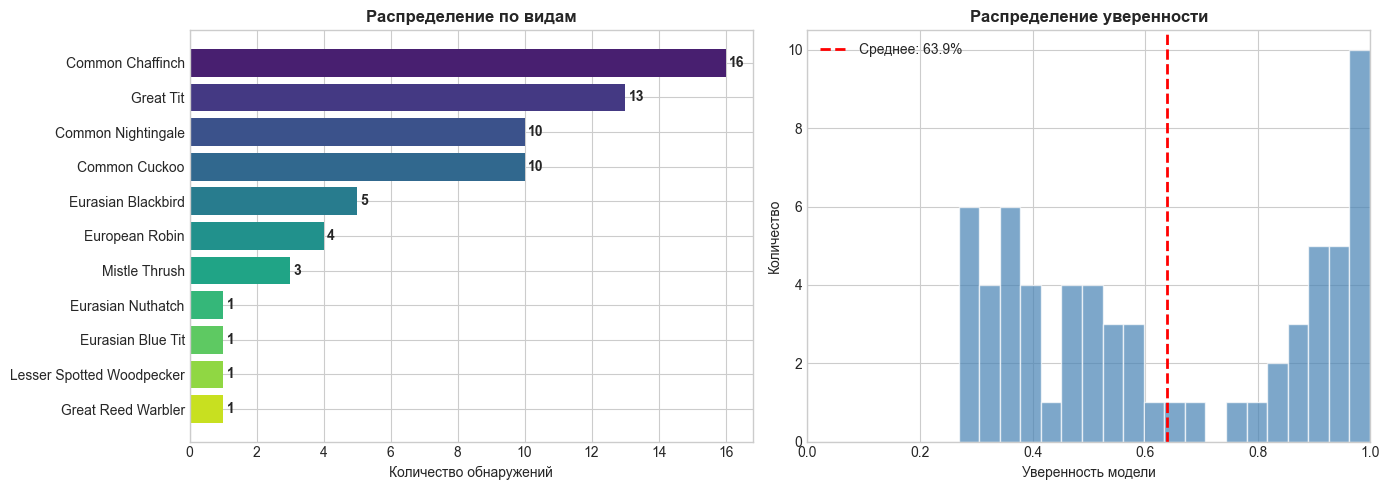

In [13]:
# Визуализация: распределение видов
if not df_detections.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Количество обнаружений по видам
    ax1 = axes[0]
    species_counts = df_detections['Вид (англ.)'].value_counts()
    colors = sns.color_palette("viridis", len(species_counts))
    bars = ax1.barh(range(len(species_counts)), species_counts.values, color=colors)
    ax1.set_yticks(range(len(species_counts)))
    ax1.set_yticklabels(species_counts.index)
    ax1.invert_yaxis()
    ax1.set_xlabel('Количество обнаружений')
    ax1.set_title('Распределение по видам', fontweight='bold')
    
    # Добавляем значения на столбцы
    for bar, count in zip(bars, species_counts.values):
        ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                 str(count), va='center', fontweight='bold')
    
    # 2. Распределение уверенности
    ax2 = axes[1]
    ax2.hist(df_detections['Уверенность'], bins=20, color='steelblue', 
             alpha=0.7, edgecolor='white')
    ax2.axvline(df_detections['Уверенность'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Среднее: {df_detections['Уверенность'].mean():.1%}")
    ax2.set_xlabel('Уверенность модели')
    ax2.set_ylabel('Количество')
    ax2.set_title('Распределение уверенности', fontweight='bold')
    ax2.legend()
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()


In [14]:
# Сохраняем результаты в CSV
RESULTS_DIR = Path("../results") if not IN_COLAB else Path("./results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

if not df_detections.empty:
    output_file = RESULTS_DIR / f"detections_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_detections.to_csv(output_file, index=False, encoding='utf-8')
    print(f"💾 Результаты сохранены: {output_file}")


💾 Результаты сохранены: ../results/detections_20251211_142025.csv


---
## 8. Выводы и применения

### Что мы сделали:
1. ✅ Загрузили тестовые аудиозаписи птиц с Xeno-Canto
2. ✅ Использовали модель BirdNET для классификации видов
3. ✅ Визуализировали спектрограммы с обнаружениями
4. ✅ Выполнили пакетную обработку нескольких файлов
5. ✅ Создали сводные таблицы и графики

### Практические применения:

- **Экологический мониторинг**: Автоматический учёт видового разнообразия птиц в заповедниках
- **Сельское хозяйство**: Мониторинг птиц-вредителей и полезных птиц
- **Городская экология**: Исследование влияния урбанизации на популяции птиц
- **Образование**: Помощь орнитологам-любителям в определении видов
- **Научные исследования**: Анализ миграций и сезонных изменений

### Ограничения модели:

- Точность зависит от качества записи и уровня шума
- Модель лучше работает с одиночными песнями (не хором птиц)
- Некоторые виды легко спутать из-за схожих вокализаций
- Региональные диалекты могут снижать точность

### Рекомендации:

1. Используйте порог уверенности ≥ 0.5 для надёжных определений
2. Записывайте в ранние утренние часы — максимальная активность птиц
3. Указывайте точные координаты — модель фильтрует виды по региону
4. Проверяйте спорные определения по спектрограмме


In [15]:
# Финальная статистика
print("\n" + "=" * 60)
print("📊 ИТОГОВАЯ СТАТИСТИКА АНАЛИЗА")
print("=" * 60)

total_files = len(batch_results)
total_detections = sum(r['num_detections'] for r in batch_results)
total_duration = sum(r['duration'] for r in batch_results)
unique_species = len(df_detections['Научное название'].unique()) if not df_detections.empty else 0

print(f"\n📁 Проанализировано файлов: {total_files}")
print(f"⏱️  Общая длительность: {total_duration:.1f} сек ({total_duration/60:.1f} мин)")
print(f"🐦 Всего обнаружений: {total_detections}")
print(f"🌿 Уникальных видов: {unique_species}")

if not df_detections.empty:
    avg_conf = df_detections['Уверенность'].mean()
    print(f"📈 Средняя уверенность: {avg_conf:.1%}")
    
    # Топ-3 вида
    print(f"\n🏆 Топ-3 обнаруженных вида:")
    top_species = df_detections.groupby('Вид (англ.)').size().sort_values(ascending=False).head(3)
    for i, (species, count) in enumerate(top_species.items(), 1):
        print(f"   {i}. {species}: {count} обнаружений")

print("\n" + "=" * 60)
print("✅ Анализ успешно завершён!")
print("=" * 60)



📊 ИТОГОВАЯ СТАТИСТИКА АНАЛИЗА

📁 Проанализировано файлов: 5
⏱️  Общая длительность: 333.8 сек (5.6 мин)
🐦 Всего обнаружений: 65
🌿 Уникальных видов: 11
📈 Средняя уверенность: 63.9%

🏆 Топ-3 обнаруженных вида:
   1. Common Chaffinch: 16 обнаружений
   2. Great Tit: 13 обнаружений
   3. Common Cuckoo: 10 обнаружений

✅ Анализ успешно завершён!


---

## 📚 Ресурсы

- **BirdNET**: https://birdnet.cornell.edu/
- **birdnetlib**: https://github.com/joeweiss/birdnetlib
- **Xeno-Canto**: https://xeno-canto.org/
- **librosa**: https://librosa.org/

---

**Автор:** Артем Еременко, 2025

*Создано для университетского практикума по машинному обучению*
